In [1]:
from google.cloud import bigquery
import os

os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="bqexercise.json"
client = bigquery.Client()

## Joins and Unions

### Joins

Recall that `INNER JOIN` pulls rows from both tables where the value in ***TABLE A, COLUMN A*** matches ***COLUMN C*** in ***TABLE B***. 

If we were to combine *all* rows in both tables, we would use a `LEFT JOIN`. 

A `LEFT JOIN` returns all rows where the two tables have matching entries along with all of the rows in the left table (matching or not). 

`RIGHT JOIN` returns all rows in the in the right table and the matching entries.

`FULL JOIN` returns all rows from both tables.


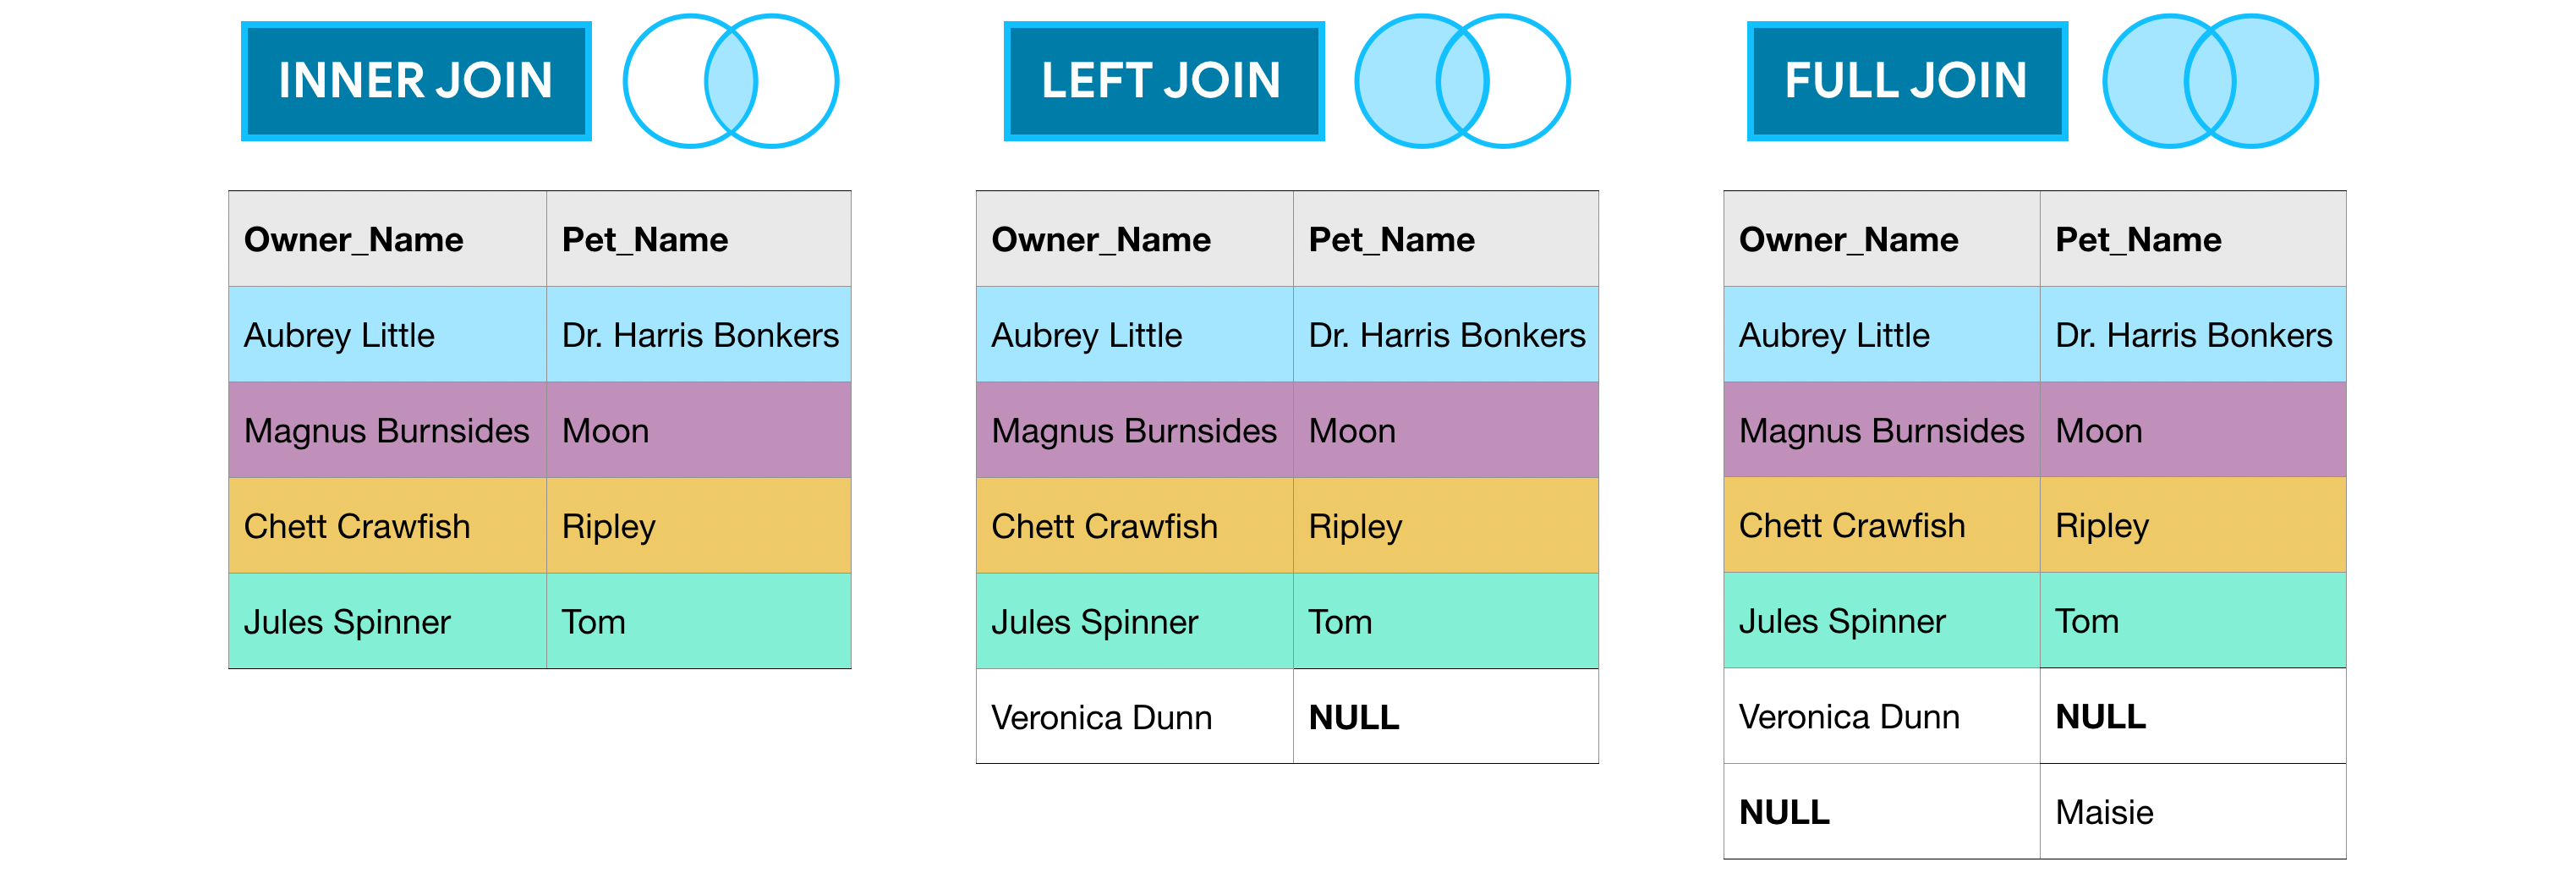

### Unions

If you need to vertically concatenate columns, you would use a `UNION`. 

To use `UNION`, the data types of both columns ***must be the same***. They can, however, have different column names. 

`UNION ALL` includes duplicate values. To get unique values, you can use `UNION DISTINCT`.

***

## EXAMPLE:

Using HackerNews dataset here.

Below is the comments table.

In [2]:
# Construct a reference to the "hacker_news" dataset
dataset_ref = client.dataset("hacker_news", project="bigquery-public-data")

# API request - fetch the dataset
dataset = client.get_dataset(dataset_ref)

# Construct a reference to the "comments" table
table_ref = dataset_ref.table("comments")

# API request - fetch the table
table = client.get_table(table_ref)

# Preview the first five lines of the table
client.list_rows(table, max_results=5).to_dataframe()

id  by author        time                   time_ts  \
0   2701393  5l     5l  1309184881 2011-06-27 14:28:01+00:00   
1   5811403  99     99  1370234048 2013-06-03 04:34:08+00:00   
2     21623  AF     AF  1178992400 2007-05-12 17:53:20+00:00   
3  10159727  EA     EA  1441206574 2015-09-02 15:09:34+00:00   
4   2988424  Iv     Iv  1315853580 2011-09-12 18:53:00+00:00   

                                                text    parent deleted  dead  \
0  And the glazier who fixed all the broken windo...   2701243    None  None   
1  Does canada have the equivalent of H1B/Green c...   5804452    None  None   
2  Speaking of Rails, there are other options in ...     21611    None  None   
3  Humans and large livestock (and maybe even pet...  10159396    None  None   
4  I must say I reacted in the same way when I re...   2988179    None  None   

   ranking  
0        0  
1        0  
2        0  
3        0  
4        0

Grabbing a new table. 

Below is the stories table.

In [3]:
# Construct a reference to the "stories" table
table_ref = dataset_ref.table("stories")

# API request - fetch the table
table = client.get_table(table_ref)

# Preview the first five lines of the table
client.list_rows(table, max_results=5).to_dataframe()

id            by  score        time                   time_ts  \
0  6940813     sarath237      0  1387536270 2013-12-20 10:44:30+00:00   
1  6991401  123123321321      0  1388508751 2013-12-31 16:52:31+00:00   
2  1531556           ssn      0  1279617234 2010-07-20 09:13:54+00:00   
3  5012398          hoju      0  1357387877 2013-01-05 12:11:17+00:00   
4  7214182         kogir      0  1401561740 2014-05-31 18:42:20+00:00   

                                               title  \
0                            Sheryl Brindo Hot Pics    
1  Are you people also put off by the culture of ...   
2                     New UI for Google Image Search   
3                       Historic website screenshots   
4                                        Placeholder   

                                                 url  \
0         http://www.youtube.com/watch?v=ym1cyxneB0Y   
1                                                      
2  http://googlesystem.blogspot.com/2010/07/googl...   
3  http://webscraping.com/blog/Generate-website-s...   
4                                                      

                                                text deleted  dead  \
0                             Sheryl Brindo Hot Pics    None  True   
1  They&#x27;re pretty explicitly &#x27;startup f...    None  True   
2                    Again following on Bing's lead.    None  None   
3  Python script to generate historic screenshots...    None  None   
4                                      Mind the gap.    None  None   

   descendants        author  
0          NaN     sarath237  
1          NaN  123123321321  
2          0.0           ssn  
3          0.0          hoju  
4          0.0         kogir

Below, we combine the two tables using a `LEFT JOIN` and we also use a CTE. (Common Table Expression)

In [8]:
# This is a query to select all stories posted on January 12, 2012 with number of comments as a column.

join_query = """
             WITH c AS
             (
                 SELECT parent, COUNT(*) as num_comments
                 FROM `bigquery-public-data.hacker_news.comments`
                 GROUP BY parent
             )
             SELECT s.id as story_id, s.by, s.title, c.num_comments
             FROM `bigquery-public-data.hacker_news.stories` as s
             LEFT JOIN c
                 ON s.id = c.parent
             WHERE EXTRACT(date FROM s.time_ts) = '2012-01-12'
             ORDER BY c.num_comments DESC             
             """

In [5]:
# Run the query, and return a pandas DataFrame
join_result = client.query(join_query).result().to_dataframe()
join_result.head()

story_id              by  \
0   3455360  sathishmanohar   
1   3456984        heyrhett   
2   3457946           rtsuk   
3   3456255          nezzor   
4   3458261         llambda   

                                               title  num_comments  
0  Sublime Text 2 Beta released with Auto-complet...          43.0  
1  Why Resumes and Code Screenings Are Obsolete w...          41.0  
2                                     Android Design          31.0  
3                                            Twss.js          24.0  
4          The Pirate Bay Will Stop Serving Torrents          22.0

When you run `.tail()` you will notice that there are quite a few `NaN`s. To see users who wrote stories or comments on January 12, 2012, we need to use `UNION DISTINCT` instead of `UNION ALL` to make sure that the user appears at least once in the query.

In [6]:
# Query to select all users who posted stories or comments on January 12, 2012.

union_query = """
              SELECT c.by
              FROM `bigquery-public-data.hacker_news.comments` as c
              WHERE EXTRACT(DATE FROM c.time_ts) = '2012-01-12'
              UNION DISTINCT
              SELECT s.by
              FROM `bigquery-public-data.hacker_news.stories` as s
              WHERE EXTRACT(DATE FROM s.time_ts) = '2012-01-12'
              """

# Run the query, and return a pandas DataFrame
union_result = client.query(union_query).result().to_dataframe()

union_result.head()

by
0  ViolentJason
1       clariee
2      mille562
3    Heniallink
4    aeliaarnol

Now we use the `len()` function to look at how many users posted on January 12, 2021.

In [7]:
len(union_result)

2483

With this in mind, say you're interested in understanding users who joined the site in January 2019. You want to track their activity on the site: when did they post their first questions and answers, if ever?

Write a query that returns the following columns:

- id - the IDs of all users who created Stack Overflow accounts in January 2019 (January 1, 2019, to January 31, 2019, inclusive)
- q_creation_date - the first time the user posted a question on the site; if the user has never posted a question, the value should be null
- a_creation_date - the first time the user posted a question on the site; if the user has never posted a question, the value should be null
    
    
    
        Note that questions and answers posted after January 31, 2019, should still be included in the results. And, all users who joined the site in January 2019 should be included (even if they have never posted a question or provided an answer).

The query from the previous question should be a nice starting point to answering this question! You'll need to use the posts_answers and posts_questions tables. You'll also need to use the users table from the Stack Overflow dataset. The relevant columns from the users table are id (the ID of each user) and creation_date (when the user joined the Stack Overflow site, in DATETIME format).

In [ ]:
                SELECT q.owner_user_id AS owner_user_id,
                    MIN(q.creation_date) AS q_creation_date,
                    MIN(a.creation_date) AS a_creation_date
                FROM `bigquery-public-data.stackoverflow.posts_questions` AS q
                    FULL JOIN `bigquery-public-data.stackoverflow.posts_answers` AS a
                ON q.owner_user_id = a.owner_user_id 
                WHERE q.creation_date >= '2019-01-01' AND q.creation_date < '2019-02-01' 
                    AND a.creation_date >= '2019-01-01' AND a.creation_date < '2019-02-01'
                GROUP BY owner_user_id

In [29]:
three_tables_query = """
                    SELECT u.id AS id, 
                        MIN(q.creation_date) AS q_creation_date, 
                        MIN(a.creation_date) AS a_creation_date
                    FROM `bigquery-public-data.stackoverflow.posts_questions` AS q
                    FULL JOIN `bigquery-public-data.stackoverflow.posts_answers` AS a
                        ON q.owner_user_id = a.owner_user_id
                    FULL JOIN `bigquery-public-data.stackoverflow.users` AS u
                        ON q.owner_user_id = u.id
                    WHERE u.creation_date >= '2019-01-01' AND u.creation_date < '2019-02-01'
                    GROUP BY id
                     """

In [32]:
# Your code here
all_users_query = """
                  SELECT q.owner_user_id
                  FROM `bigquery-public-data.stackoverflow.posts_questions` as q
                  WHERE EXTRACT(DATE FROM q.creation_date) = '2019-01-01'
                  UNION DISTINCT
                  SELECT a.owner_user_id
                  FROM `bigquery-public-data.stackoverflow.posts_answers` AS a
                  WHERE EXTRACT (DATE FROM a.creation_date) = '2019-01-01'
                  """

***

## Analytic Functions

All analytic functions have an `OVER` clause. It defines the sets of rows used in each calculation.

`OVER` clauses have three optional parts:
    
1. `PARTITION BY` clause divides the rows of tables into ***different groups***.
2. `ORDER BY` cluase defines an ordering within each partition.
3. `ROWS BETWEEN 1 PRECEDING AND CURRENT ROW` is known as the ***WINDOW FRAME*** clause. It identifies the set of rows used in each calculation. We can refer to this group of rows as a window.

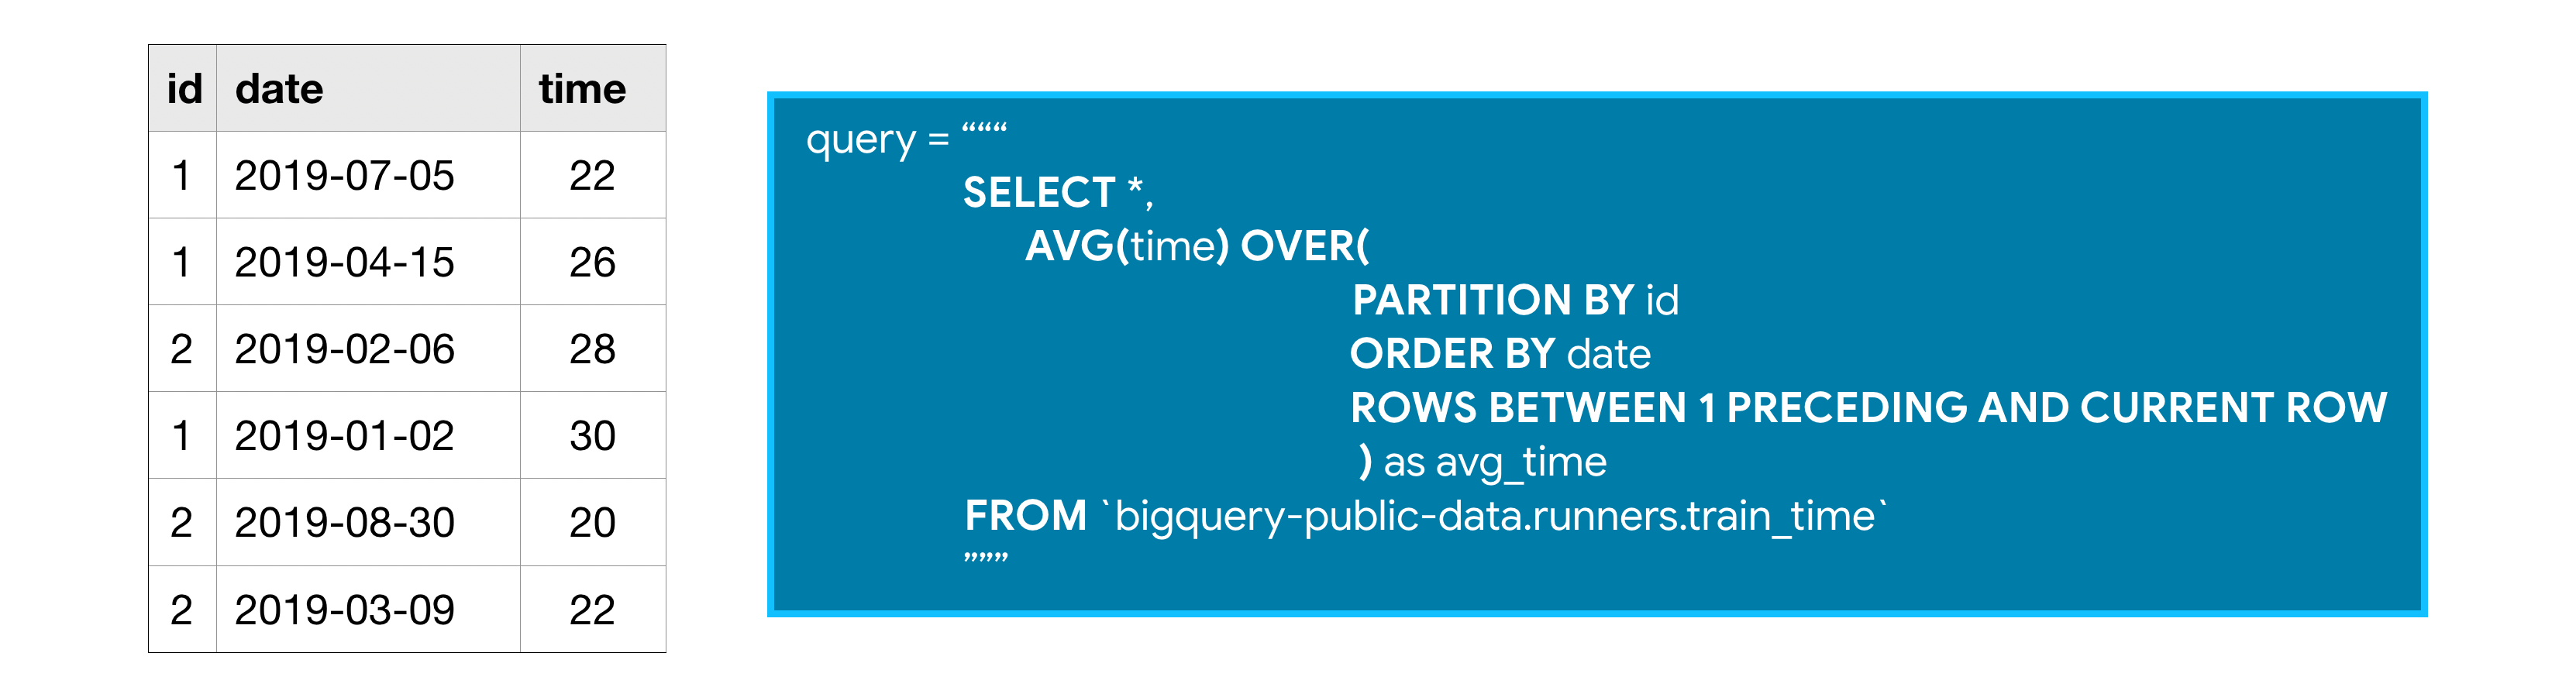

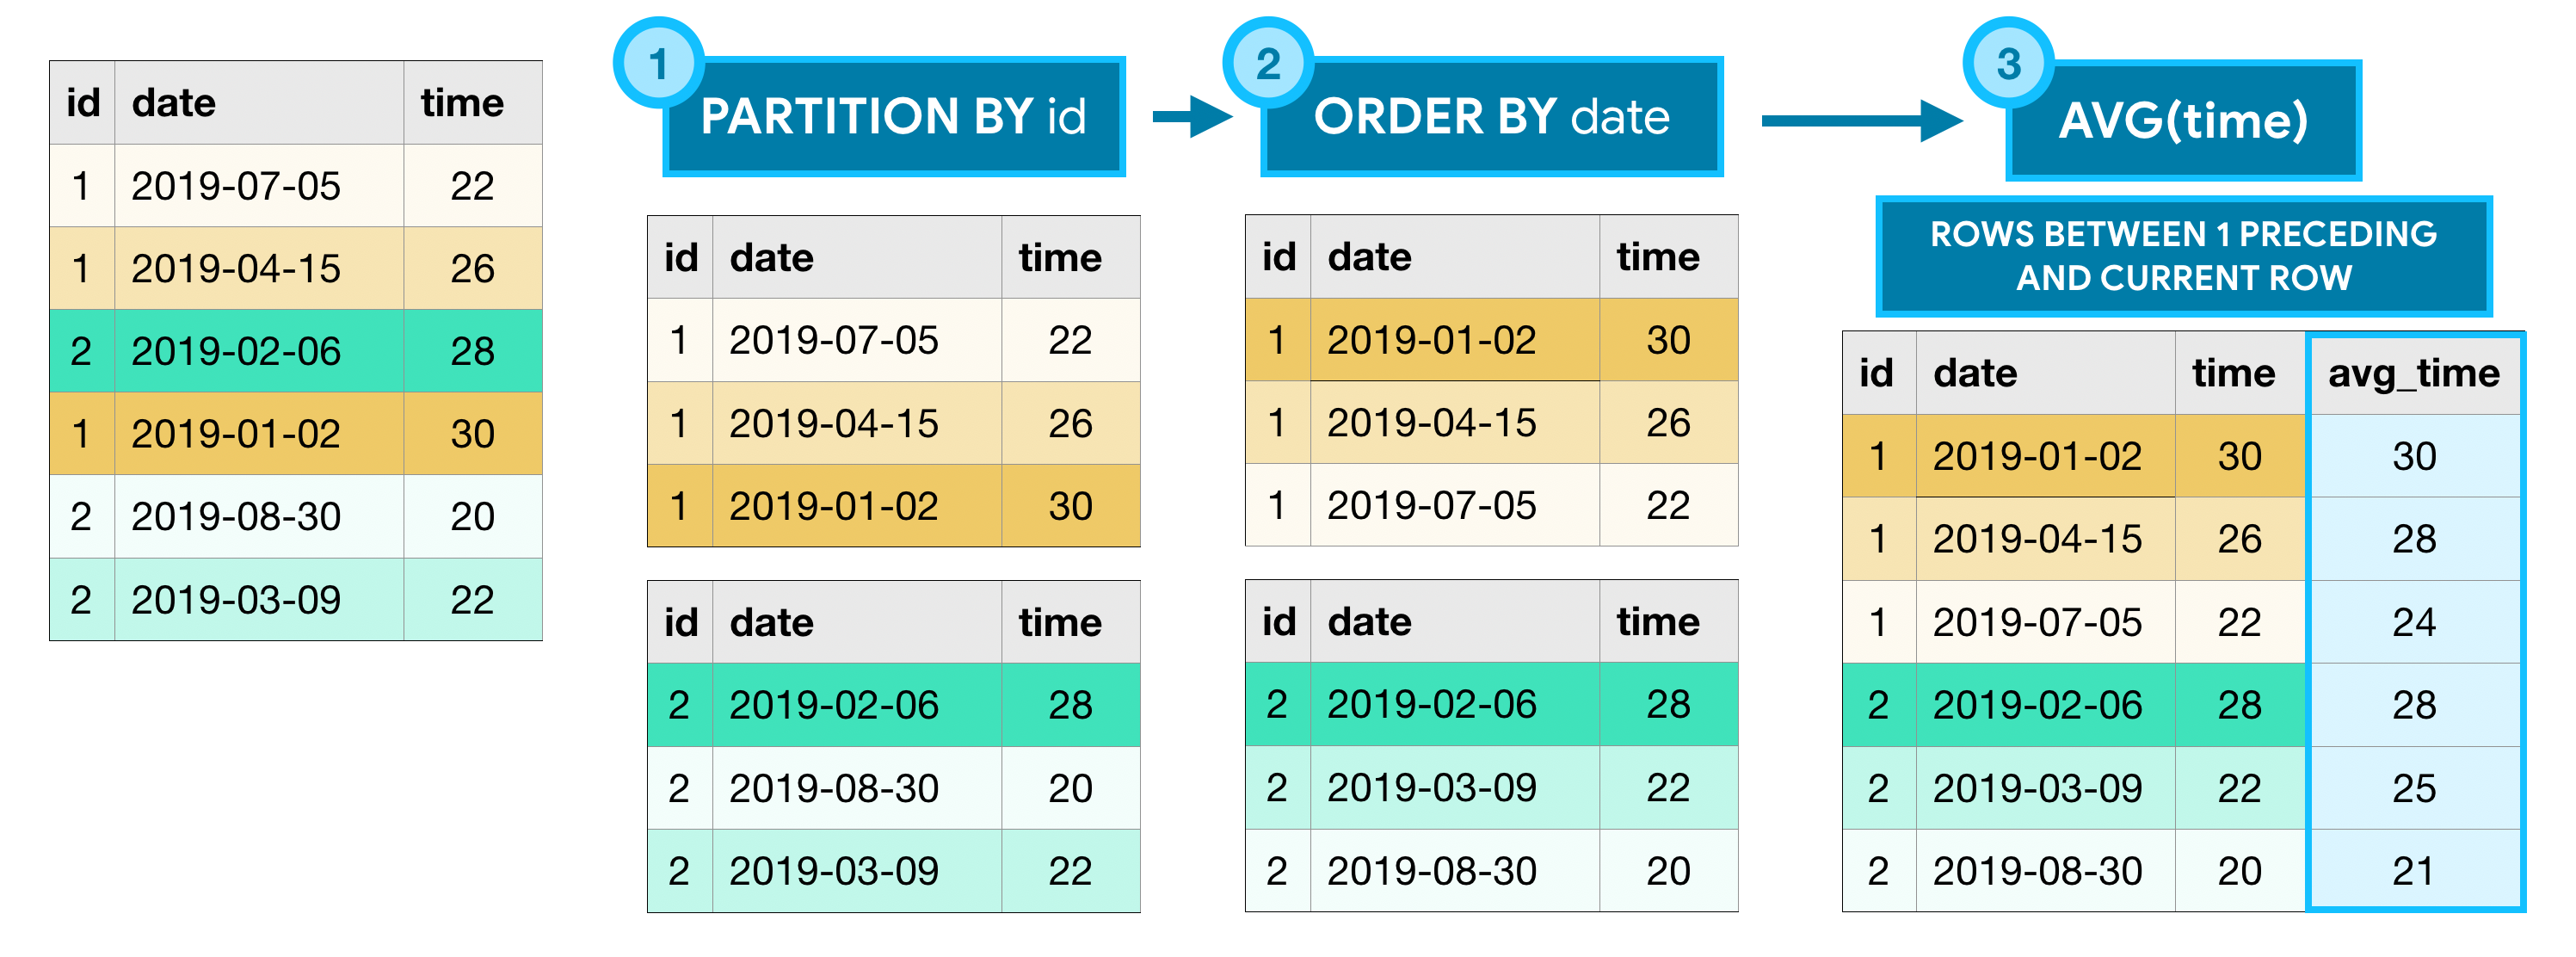

There are many ways to write ***window clauses***.

- `ROWS BETWEEN 1 PRECEDING AND CURRENT ROW`: the previous row and the current row.
- `ROWS BETWEEN 3 PRECEDING AND 1 FOLLOWING`: the 3 previous rows, the current row, and the following row.
- `ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING`: all rows in the partition.

***

### Analytic functions:

#### 1. Analytic aggregate functions

`AVG()` is an aggregate function. The ***OVER*** clause is what ensures that it is treated as an analytic aggregate function. Aggregate functions take all of the values within the window as input and returns a single value.

- `MIN()` or `MAX()`: Returns minimum or maximum value.
- `AVG()` or `SUM()`: Returns the average or the sum of input values.
- `COUNT()`: Returns the number of rows in the input.

#### 2. Analytic navigation functions

Navigation functions assign a value based on the value in a different row than the current row.

- `FIRST_VALUE()` or `LAST_VALUE()`: Returns the first or last value in the input. *(Think .head() or .tail() in Python)*
- `LEAD()` or `LAG()`: Returns the value on a subsequent or preceding row.

#### 3. Analytic numbering functions

Numbering functions assign integer values to each row based on the ordering.

- `ROW_NUMBER()`: Returns the order in which rows appear in the input starting with `1`.
- `RANK()`: All rows with the same value in the ordering column receive the same rank, where the next row receives a rank value which increments by the number of rows with the previous rank value.

***

## EXAMPLE: 

In [10]:
# Construct a reference to the "san_francisco" dataset
dataset_ref = client.dataset("san_francisco", project="bigquery-public-data")

# API request - fetch the dataset
dataset = client.get_dataset(dataset_ref)

# Construct a reference to the "bikeshare_trips" table
table_ref = dataset_ref.table("bikeshare_trips")

# API request - fetch the table
table = client.get_table(table_ref)

# Preview the first five lines of the table
client.list_rows(table, max_results=5).to_dataframe()

trip_id  duration_sec                start_date start_station_name  \
0   944732          2618 2015-09-24 17:22:00+00:00              Mezes   
1   984595          5957 2015-10-25 18:12:00+00:00              Mezes   
2   984596          5913 2015-10-25 18:13:00+00:00              Mezes   
3  1129385          6079 2016-03-18 10:33:00+00:00              Mezes   
4  1030383          5780 2015-12-06 10:52:00+00:00              Mezes   

   start_station_id                  end_date end_station_name  \
0                83 2015-09-24 18:06:00+00:00            Mezes   
1                83 2015-10-25 19:51:00+00:00            Mezes   
2                83 2015-10-25 19:51:00+00:00            Mezes   
3                83 2016-03-18 12:14:00+00:00            Mezes   
4                83 2015-12-06 12:28:00+00:00            Mezes   

   end_station_id  bike_number zip_code subscriber_type  
0              83          653    94063        Customer  
1              83           52      nil        Customer  
2              83          121      nil        Customer  
3              83          208    94070        Customer  
4              83           44    94064        Customer

In [14]:
# Query to count the cumulative number of trips per day:

num_trips_query = """
                  WITH trips_by_day AS
                  (
                  SELECT DATE(start_date) as trip_date,
                      COUNT(*) as num_trips
                  FROM `bigquery-public-data.san_francisco.bikeshare_trips`
                  WHERE EXTRACT(YEAR FROM start_date) = 2015
                  GROUP BY trip_date
                  )
                  
                  SELECT *,
                      SUM(num_trips)
                          OVER(
                              ORDER BY trip_date
                              ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
                              ) AS cumulative_trips
                  FROM trips_by_day
                  """

# Run the query, and return a pandas DataFrame
num_trips_result = client.query(num_trips_query).result().to_dataframe()
num_trips_result.head()

trip_date  num_trips  cumulative_trips
0  2015-01-01        181               181
1  2015-01-02        428               609
2  2015-01-03        283               892
3  2015-01-04        206              1098
4  2015-01-05       1186              2284

The query above uses a CTE to calculate the daily number of trips. Then we use `SUM()` as an aggregate function.

- Since there is no `PARTITION BY()`, the entire table is treated as a single partition.
- `ORDER BY` orders the rows by date (earliest to latest).
- `ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW` ensures that all rows up to and including current date are sued to calculate the sum.

In [18]:
# Query to track beginning and ending stations on October 25, 2015 to each bike:

start_end_query = """
                  SELECT bike_number,
                      TIME(start_date) as trip_time,
                      FIRST_VALUE(start_station_id)
                          OVER (
                                PARTITION BY bike_number
                                ORDER BY start_date
                                ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING
                                ) AS first_station_id,
                      LAST_VALUE(end_station_id)
                          OVER(
                               PARTITION BY bike_number
                               ORDER BY start_date
                               ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING
                               ) AS last_station_id,
                      start_station_id,
                      end_station_id
                    FROM `bigquery-public-data.san_francisco.bikeshare_trips`
                    WHERE DATE(start_date) = '2015-10-25'
                    """

# Run the query, and return a pandas DataFrame
start_end_result = client.query(start_end_query).result().to_dataframe()
start_end_result.head()

bike_number trip_time  first_station_id  last_station_id  start_station_id  \
0          178  14:01:00                61               76                61   
1          178  16:11:00                61               76                60   
2          322  11:26:00                49               70                49   
3          579  15:01:00                46               70                46   
4          579  23:14:00                46               70                76   

   end_station_id  
0              60  
1              76  
2              70  
3              76  
4              70

The query above uses `FIRST_VALUE()` and `LAST_VALUE()` as analytic functions.

- `PARTITION BY` breaks data into partitions based on the `bike_number` column. Since the bike numbers are unique identifiers, this ensures the calculations performed are done separately for each bike.
- `ORDER BY` puts the rows in chronological order.
- `ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING` ensures for each row, its entire partition is used to perform the calculation. 

***

### Nested and Repeated Data

#### Nested Data

Nested columns have type ***STRUCT*** or type ***RECORD***. 

In order to query a column with nested data, we will need to identify each field in the context of the column that contains it:


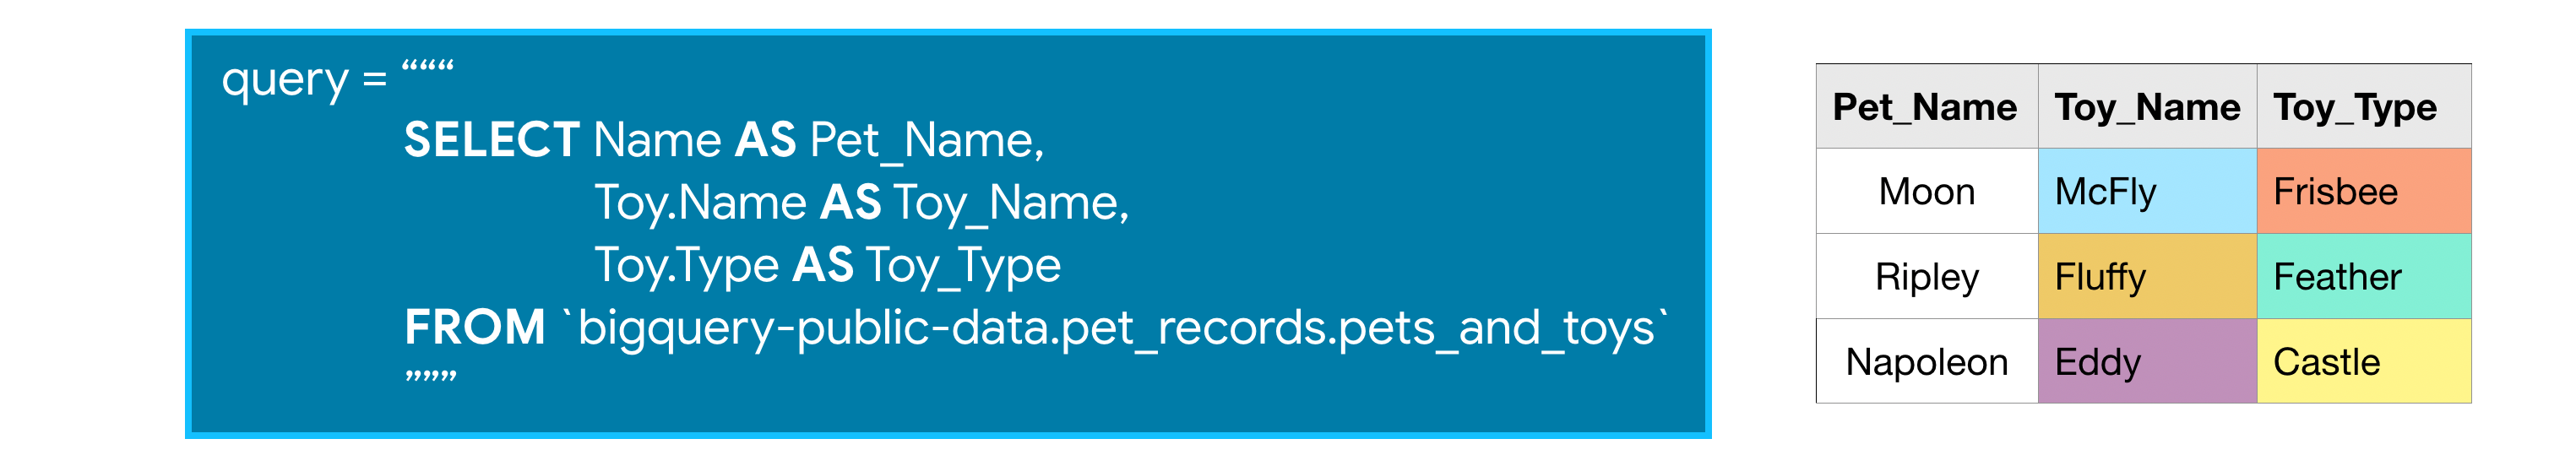

#### Repeated Data

What happens when an ID is linked to multiple rows? In this case, to collapse this information into a single table, we need to leverage a different datatype.

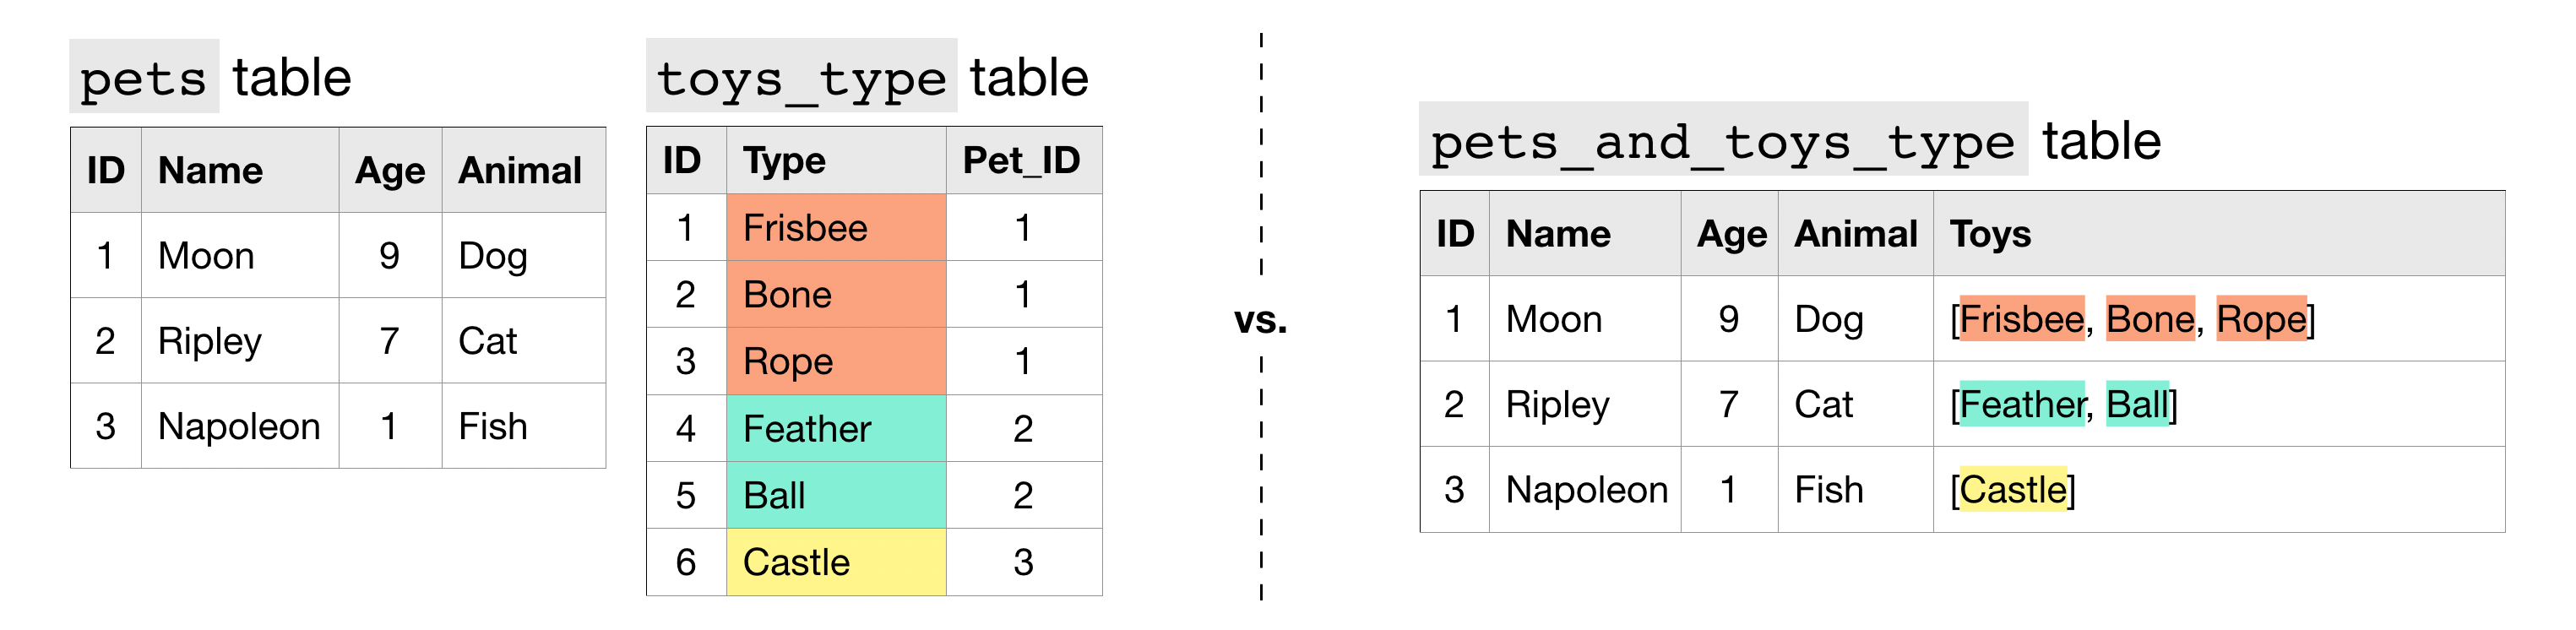

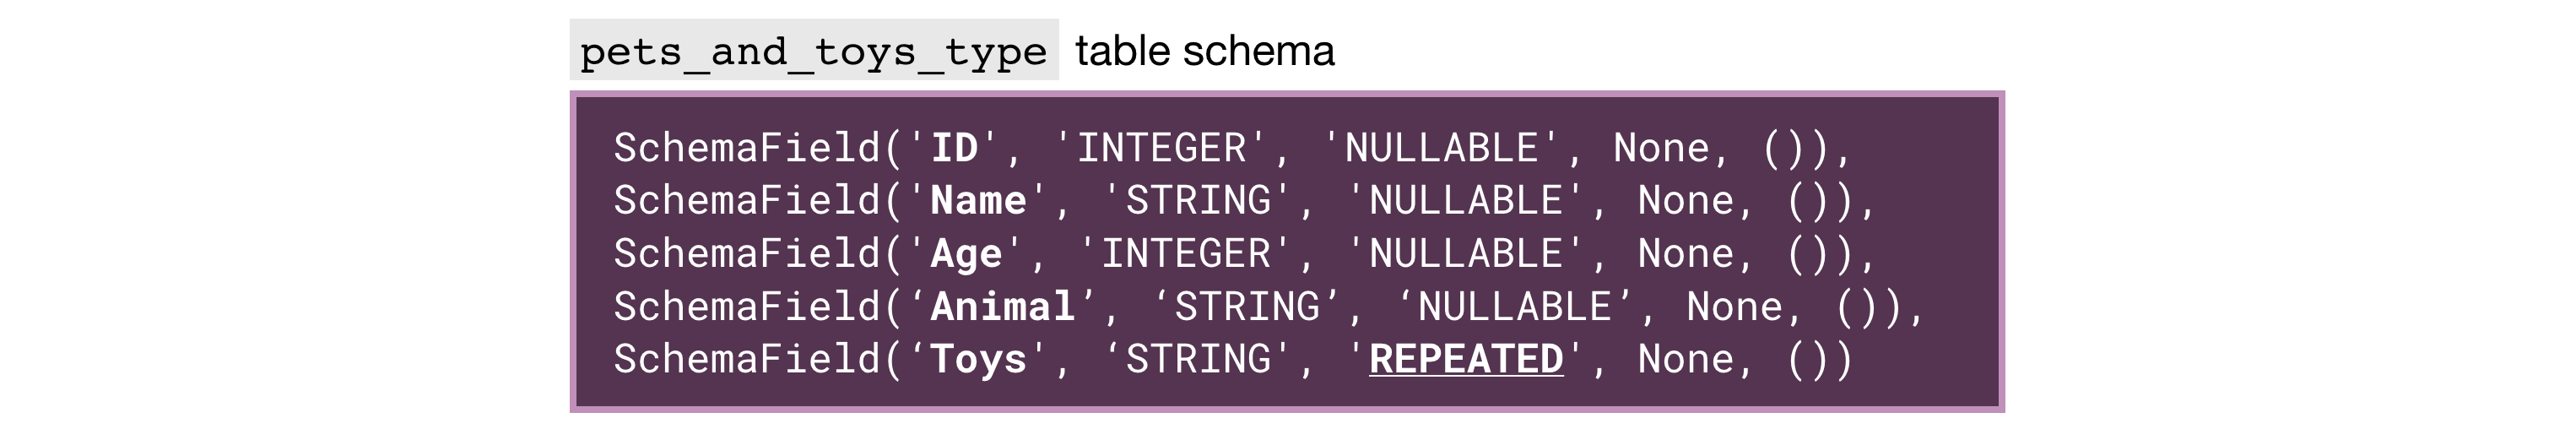

Each entry in a repeated field is called an ***array***. When querying repeated data, we need to put the name of the column containing the repeated data inside an `UNNEST()` function. 

This flattens the repeated data, which is then appended to the right side of the table, so we have one element on each row.

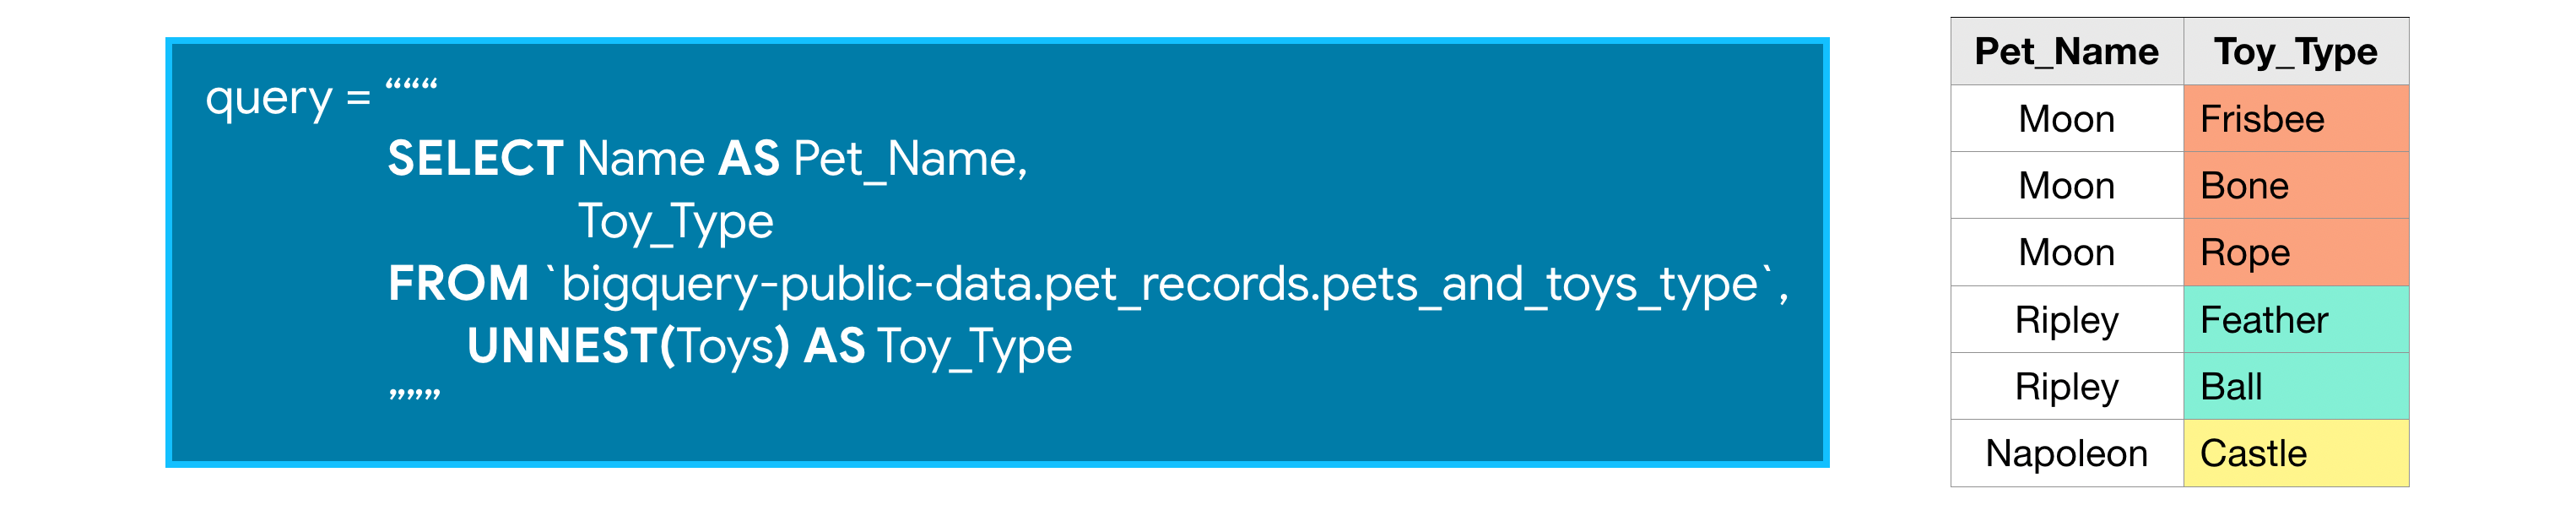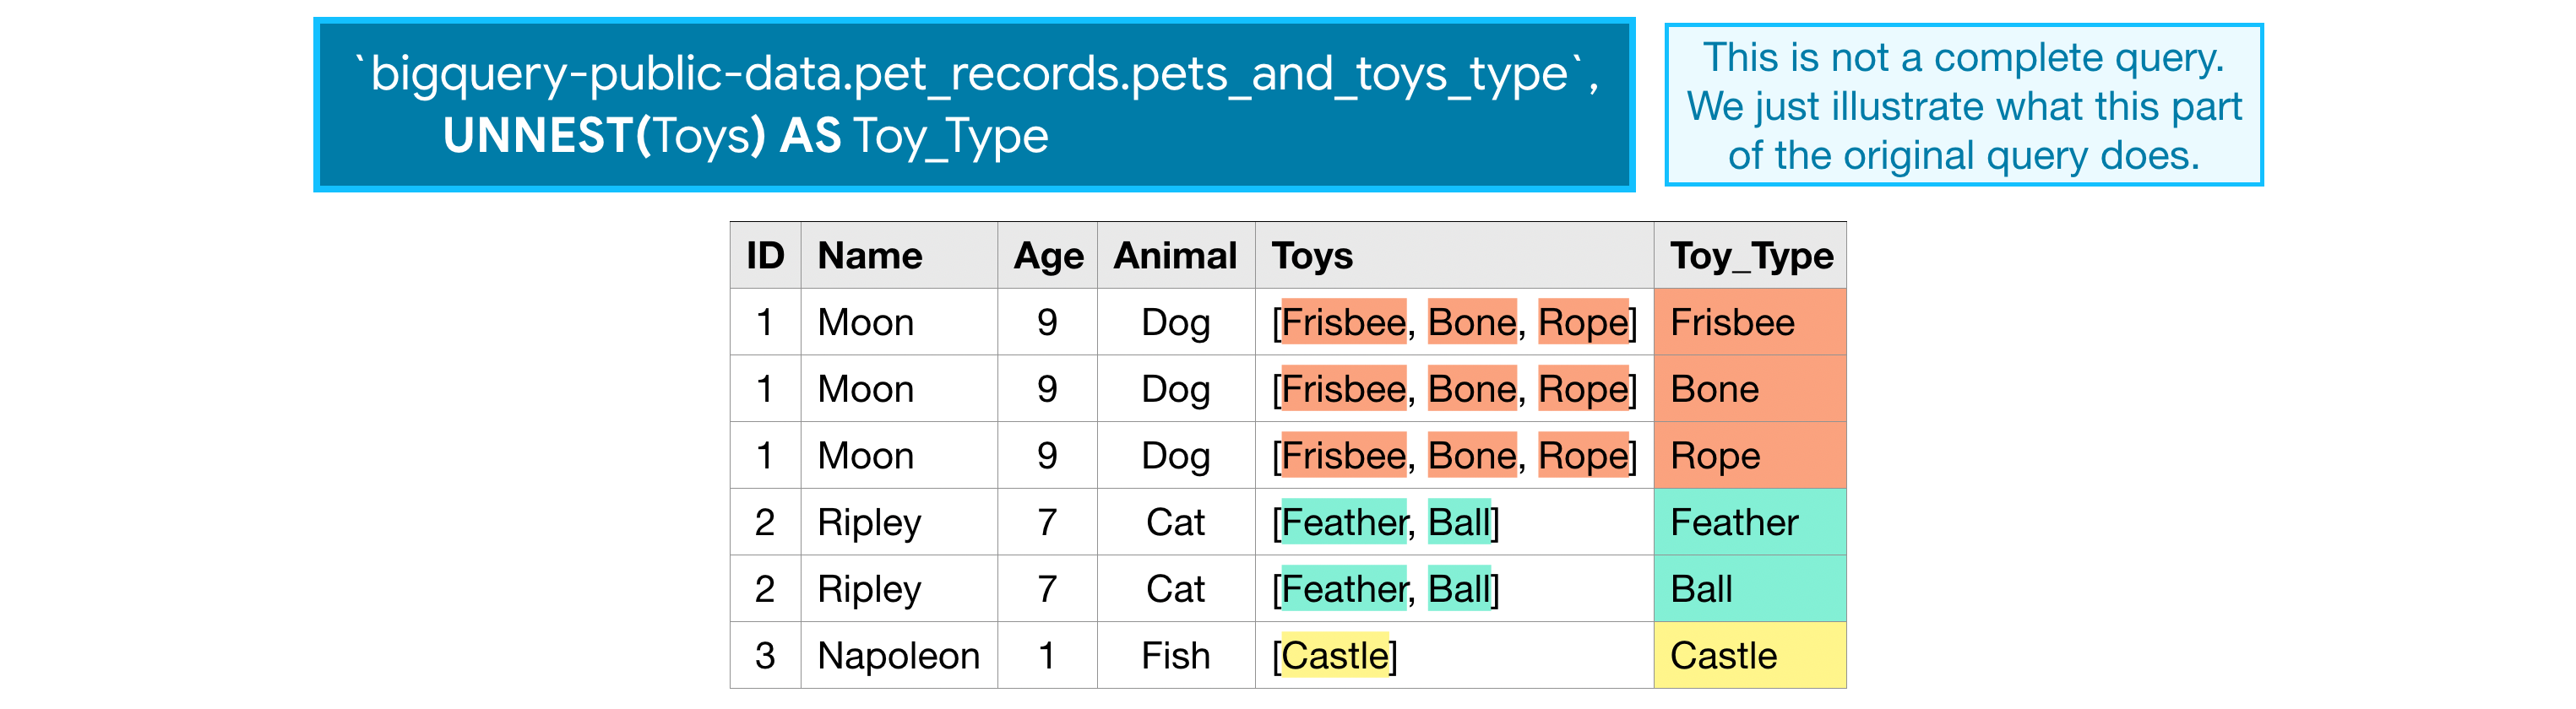

#### Nested AND repeated data

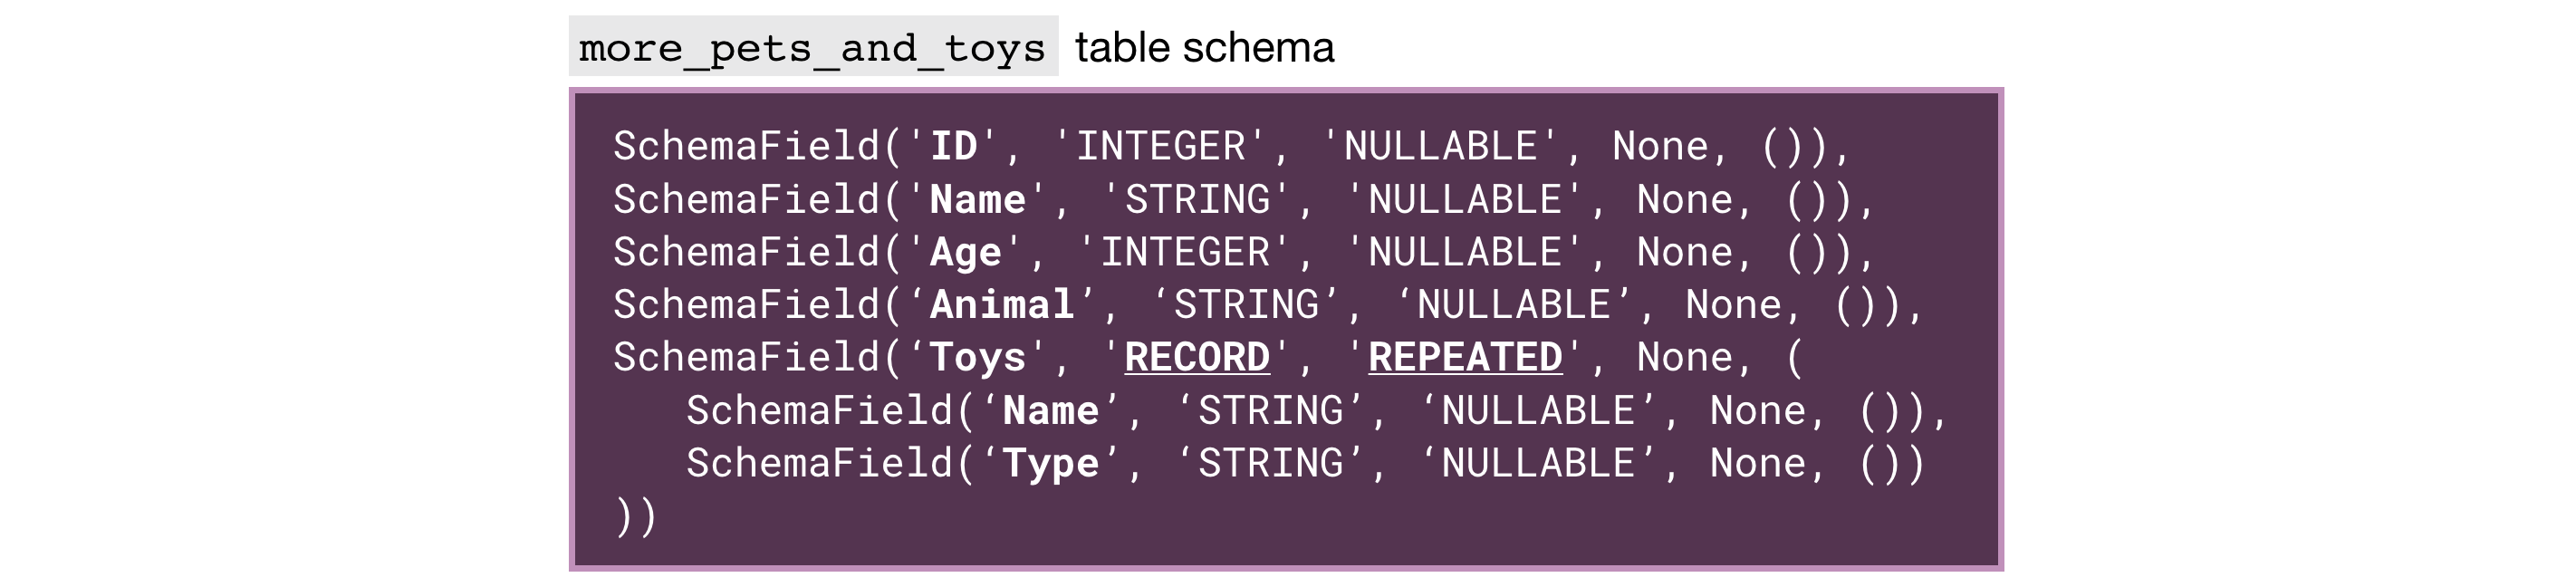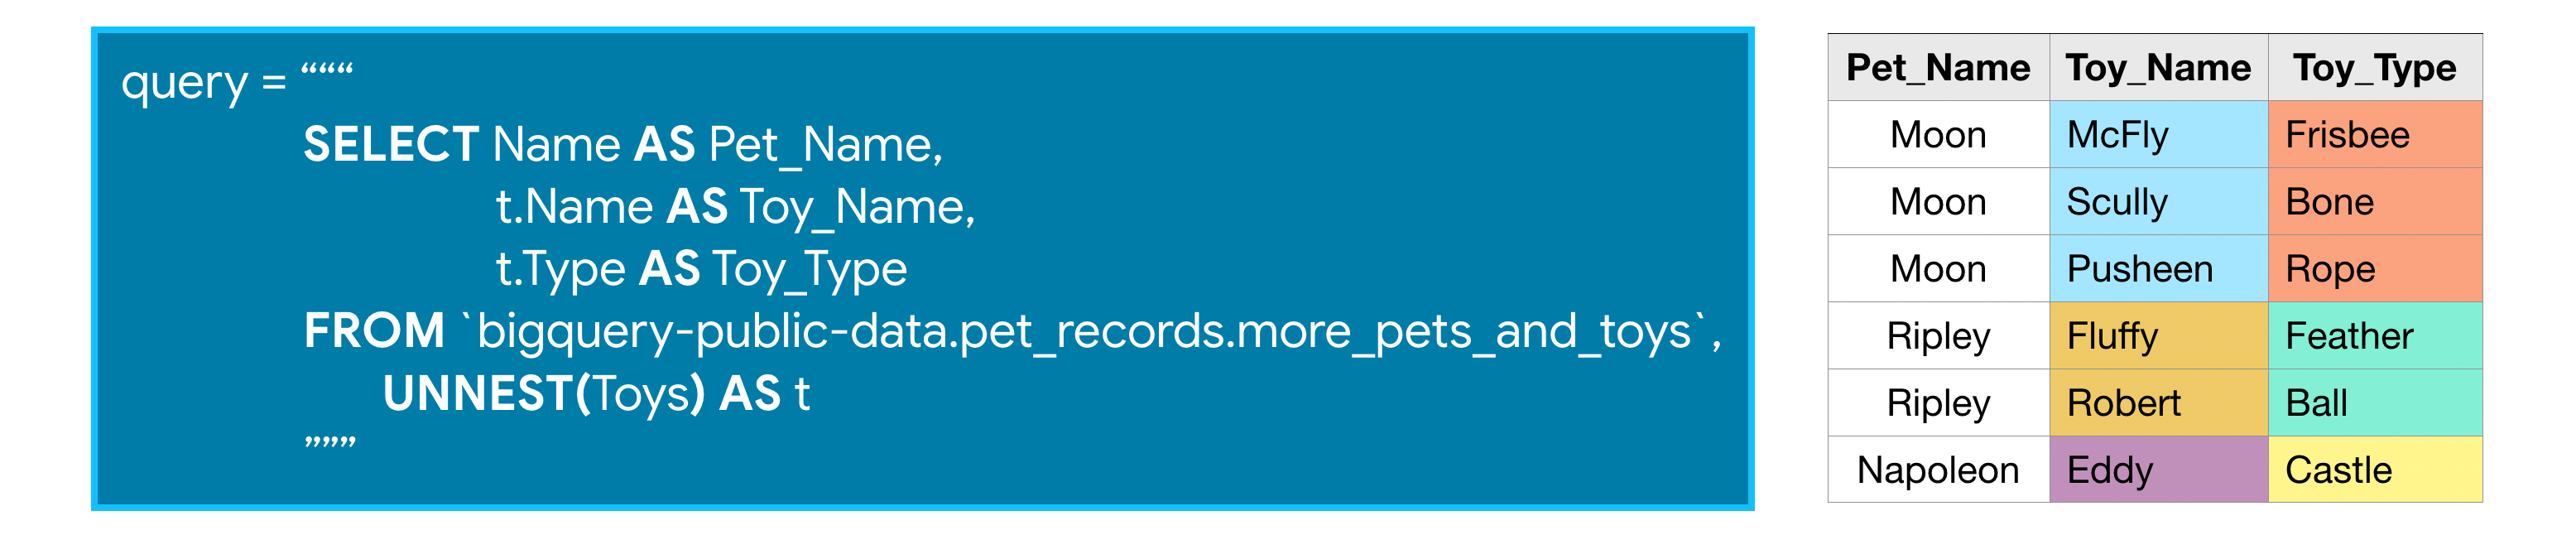

***Flatten*** `Toys` with the `UNNEST()` function and because it now has an alias of `t`, refer back to it as `t.Name` and `t.Type`.

***

### EXAMPLE:

In [19]:
# Construct a reference to the "google_analytics_sample" dataset
dataset_ref = client.dataset("google_analytics_sample", project="bigquery-public-data")

# Construct a reference to the "ga_sessions_20170801" table
table_ref = dataset_ref.table("ga_sessions_20170801")

# API request - fetch the table
table = client.get_table(table_ref)

# Preview the first five lines of the table
client.list_rows(table, max_results=5).to_dataframe()

visitorId  visitNumber     visitId  visitStartTime      date  \
0        NaN            1  1501583974      1501583974  20170801   
1        NaN            1  1501616585      1501616585  20170801   
2        NaN            1  1501583344      1501583344  20170801   
3        NaN            1  1501573386      1501573386  20170801   
4        NaN            8  1501651467      1501651467  20170801   

                                              totals  \
0  {'visits': 1, 'hits': 1, 'pageviews': 1, 'time...   
1  {'visits': 1, 'hits': 1, 'pageviews': 1, 'time...   
2  {'visits': 1, 'hits': 1, 'pageviews': 1, 'time...   
3  {'visits': 1, 'hits': 1, 'pageviews': 1, 'time...   
4  {'visits': 1, 'hits': 1, 'pageviews': 1, 'time...   

                                       trafficSource  \
0  {'referralPath': None, 'campaign': '(not set)'...   
1  {'referralPath': None, 'campaign': '(not set)'...   
2  {'referralPath': None, 'campaign': '(not set)'...   
3  {'referralPath': None, 'campaign': '(not set)'...   
4  {'referralPath': None, 'campaign': '(not set)'...   

                                              device  \
0  {'browser': 'Chrome', 'browserVersion': 'not a...   
1  {'browser': 'Chrome', 'browserVersion': 'not a...   
2  {'browser': 'Chrome', 'browserVersion': 'not a...   
3  {'browser': 'Chrome', 'browserVersion': 'not a...   
4  {'browser': 'Chrome', 'browserVersion': 'not a...   

                                          geoNetwork  \
0  {'continent': 'Americas', 'subContinent': 'Car...   
1  {'continent': 'Americas', 'subContinent': 'Nor...   
2  {'continent': 'Asia', 'subContinent': 'Souther...   
3  {'continent': 'Europe', 'subContinent': 'Weste...   
4  {'continent': 'Americas', 'subContinent': 'Nor...   

                           customDimensions  \
0                                        []   
1  [{'index': 4, 'value': 'North America'}]   
2           [{'index': 4, 'value': 'APAC'}]   
3           [{'index': 4, 'value': 'EMEA'}]   
4  [{'index': 4, 'value': 'North America'}]   

                                                hits        fullVisitorId  \
0  [{'hitNumber': 1, 'time': 0, 'hour': 3, 'minut...  2248281639583218707   
1  [{'hitNumber': 1, 'time': 0, 'hour': 12, 'minu...  8647436381089107732   
2  [{'hitNumber': 1, 'time': 0, 'hour': 3, 'minut...  2055839700856389632   
3  [{'hitNumber': 1, 'time': 0, 'hour': 0, 'minut...  0750846065342433129   
4  [{'hitNumber': 1, 'time': 0, 'hour': 22, 'minu...  0573427169410921198   

  userId clientId channelGrouping  socialEngagementType  
0   None     None  Organic Search  Not Socially Engaged  
1   None     None  Organic Search  Not Socially Engaged  
2   None     None  Organic Search  Not Socially Engaged  
3   None     None          Direct  Not Socially Engaged  
4   None     None  Organic Search  Not Socially Engaged

In [20]:
print("SCHEMA field for the 'totals' column:\n")
print(table.schema[5])

print("\nSCHEMA field for the 'device' column:\n")
print(table.schema[7])

SCHEMA field for the 'totals' column:

SchemaField('totals', 'RECORD', 'NULLABLE', None, (SchemaField('visits', 'INTEGER', 'NULLABLE', None, (), ()), SchemaField('hits', 'INTEGER', 'NULLABLE', None, (), ()), SchemaField('pageviews', 'INTEGER', 'NULLABLE', None, (), ()), SchemaField('timeOnSite', 'INTEGER', 'NULLABLE', None, (), ()), SchemaField('bounces', 'INTEGER', 'NULLABLE', None, (), ()), SchemaField('transactions', 'INTEGER', 'NULLABLE', None, (), ()), SchemaField('transactionRevenue', 'INTEGER', 'NULLABLE', None, (), ()), SchemaField('newVisits', 'INTEGER', 'NULLABLE', None, (), ()), SchemaField('screenviews', 'INTEGER', 'NULLABLE', None, (), ()), SchemaField('uniqueScreenviews', 'INTEGER', 'NULLABLE', None, (), ()), SchemaField('timeOnScreen', 'INTEGER', 'NULLABLE', None, (), ()), SchemaField('totalTransactionRevenue', 'INTEGER', 'NULLABLE', None, (), ()), SchemaField('sessionQualityDim', 'INTEGER', 'NULLABLE', None, (), ())), ())

SCHEMA field for the 'device' column:

SchemaFi

In [25]:
# Query to count the number of transactions per browser: 

transaction_query = """
                    SELECT device.browser As device_browser,
                        SUM(totals.transactions) as total_transactions
                    FROM `bigquery-public-data.google_analytics_sample.ga_sessions_20170801`
                    GROUP BY device_browser
                    ORDER BY total_transactions DESC
                    """

result = client.query(transaction_query).result().to_dataframe()
result.head()

device_browser  total_transactions
0             Chrome                41.0
1             Safari                 3.0
2            Firefox                 1.0
3  Internet Explorer                 NaN
4         UC Browser                 NaN

By storing the information in the "device" and "totals" columns as STRUCTs, expensive JOINs are avoided. This increases performance! 

In [26]:
# Query to find the most popular landing page on the website:

popular_query = """
                SELECT hits.page.pagePath as path,
                    COUNT(hits.page.pagePath) as counts
                FROM `bigquery-public-data.google_analytics_sample.ga_sessions_20170801`,
                    UNNEST(hits) as hits
                WHERE hits.type = 'PAGE' and hits.hitNumber = 1
                GROUP BY path
                ORDER BY counts DESC
                """

result = client.query(popular_query).result().to_dataframe()
result.head()

path  counts
0                                        /home    1257
1       /google+redesign/shop+by+brand/youtube     587
2  /google+redesign/apparel/mens/mens+t+shirts     117
3                                 /signin.html      78
4                                 /basket.html      35

In [ ]:
For this question, you'll restrict your attention to the repository with name 'polyrabbit/polyglot'.

Write a query that returns a table with one row for each language in this repository. The table should have two columns:

name - the name of the programming language
bytes - the total number of bytes of that programming language
Sort the table by the bytes column so that programming languages that take up more space in the repo appear first.

# Your code here
all_langs_query = """
                  SELECT l.name as name, SUM(l.bytes) as bytes
                  FROM `bigquery-public-data.github_repos.languages`,
                      UNNEST(language) as l
                  WHERE repo_name = 'polyrabbit/polyglot'
                  GROUP BY name
                  ORDER BY bytes DESC
                  """